## <a name="p0">Introduction</a>

* **Natural Language Processing (NLP):** The discipline of computer science, artificial intelligence and linguistics that is concerned with the creation of computational models that process and understand natural language. These include: making the computer understand the semantic grouping of words (e.g. cat and dog are semantically more similar than cat and spoon), text to speech, language translation and many more

* **Sentiment Analysis:** It is the interpretation and classification of emotions (positive, negative and neutral) within text data using text analysis techniques. Sentiment analysis allows organizations to identify public sentiment towards certain words or topics.

In this notebook, we'll develop a **Sentiment Analysis model** to categorize a tweet as **Positive or Negative.**

## <a name="p00">Table of Contents</a>
1. [Importing modules](#p1)
2. [Importing dataset](#p2)
3. [Preprocessing Text](#p3)
4. [Analysing data](#p4)
5. [Splitting data](#p5)
6. [TF-IDF Vectoriser](#p6)
7. [Transforming Dataset](#p7)
8. [Creating and Evaluating Models](#p8)
    * [MultinomialNB Model](#p8-1)
    * [LinearSVC Model](#p8-2)
    * [Logistic Regression Model](#p8-3)
9. [Saving the Models](#p9)

## <a name="p1">Importing modules</a>

In [ ]:
# utilities
import numpy as np
import pandas as pd
import os 
import sys
import time
from tqdm import tqdm 

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# sklearn
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

#helper functions
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from helpers.text_preprocessor import preprocess_text
from helpers.model_pipeline import model_Evaluate

## <a name="p2">Importing dataset</a>
The dataset being used is the **sentiment140 dataset**. It contains 1,600,000 tweets extracted using the **Twitter API**. The tweets have been annotated **(0 = Negative, 4 = Positive)** and they can be used to detect sentiment.
 
*[The training data isn't perfectly categorised as it has been created by tagging the text according to the emoji present. So, any model built using this dataset may have lower than expected accuracy, since the dataset isn't perfectly categorised.]*

**It contains the following 6 fields:**
1. **sentiment**: the polarity of the tweet *(0 = negative, 4 = positive)*
2. **ids**: The id of the tweet *(2087)*
3. **date**: the date of the tweet *(Sat May 16 23:58:44 UTC 2009)*
4. **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
5. **user**: the user that tweeted *(robotickilldozr)*
6. **text**: the text of the tweet *(Lyx is cool)*

We require only the **sentiment** and **text** fields, so we discard the rest.

Furthermore, we're changing the **sentiment** field so that it has new values to reflect the sentiment. **(0 = Negative, 1 = Positive)**

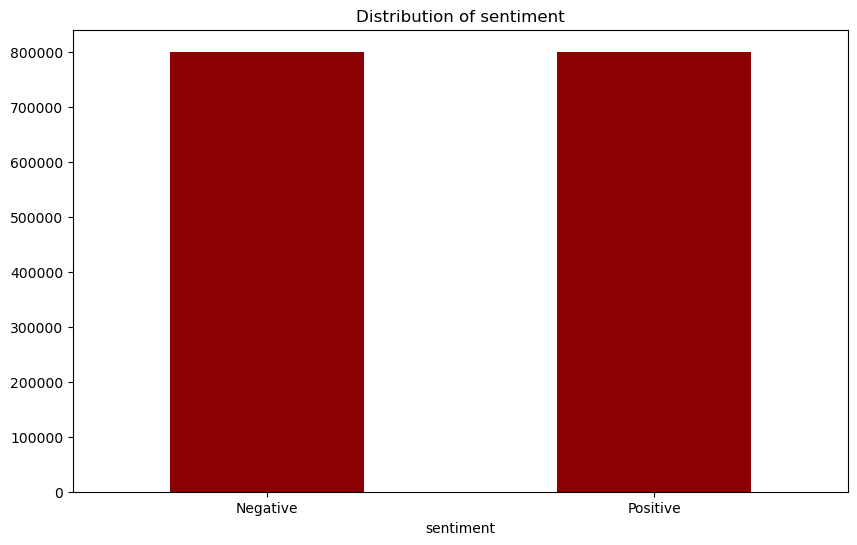

In [ ]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

dataset = pd.read_csv(
    "../data/raw/training.1600000.processed.noemoticon.csv",
    encoding=DATASET_ENCODING,
    names=DATASET_COLUMNS,
    engine="pyarrow",
)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]

# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Creating a new figure with the desired size
fig = plt.figure(figsize=(10,6))

# Creating a new subplot
ax = fig.add_subplot(1, 1, 1)

# Plotting the distribution for dataset.
dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of sentiment',
                                          legend=False, color='darkred', ax=ax)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
tweets, sentiment = list(dataset['text']), list(dataset['sentiment'])

It appears that there are 800,000 instances of negative sentiment and 800,000 instances of positive sentiment in the dataset. This suggests that the dataset is balanced with respect to sentiment labels, which is a good thing as it allows for more accurate training of sentiment analysis models.

## <a name="p3">Preprocess Text</a>
**Text Preprocessing** is traditionally an important step for **Natural Language Processing (NLP)** tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

**The Preprocessing steps taken are:**
1. **Lower Casing:** Each text is converted to lowercase.
2. **Replacing URLs:** Links starting with **"http" or "https" or "www"** are replaced by **""**.
3. **Replacing Emojis:** Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. *(eg: ":)" to "smile")*
4. **Replacing Usernames:** Replace @Usernames with word **""**. *(eg: "@Kaggle" to "")*
5. **Removing Non-Alphabets:** Replacing characters except Digits and Alphabets with a space.
6. **Removing Consecutive letters:** 3 or more consecutive letters are replaced by 2 letters. *(eg: "Heyyyy" to "Heyy")*
7. **Removing Short Words:** Words with length less than 2 are removed.
8. **Removing Stopwords:** Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. *(eg: "the", "he", "have")*
9. **Lemmatizing:** Lemmatization is the process of converting a word to its base form. *(e.g: “Great” to “Good”)*

In [ ]:
t = time.time()
processedTweets = []

for tweet in tqdm(tweets):
    processed_text = preprocess_text(tweet)
    processedTweets.append(processed_text)

print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

dataset['text'] = processedTweets
dataset.to_csv('../data/processed/training.1600000.processed.noemoticon_Processed_v1.csv')

100%|██████████| 1600000/1600000 [02:30<00:00, 10642.14it/s]


Text Preprocessing complete.
Time Taken: 150 seconds


## <a name="p4">Analyzing the data</a>
Now we're going to analyse the preprocessed data to get an understanding of it. We'll plot **Word Clouds** for **Positive and Negative** tweets from our dataset and see which words occur the most.

### Word-Cloud for Negative tweets.

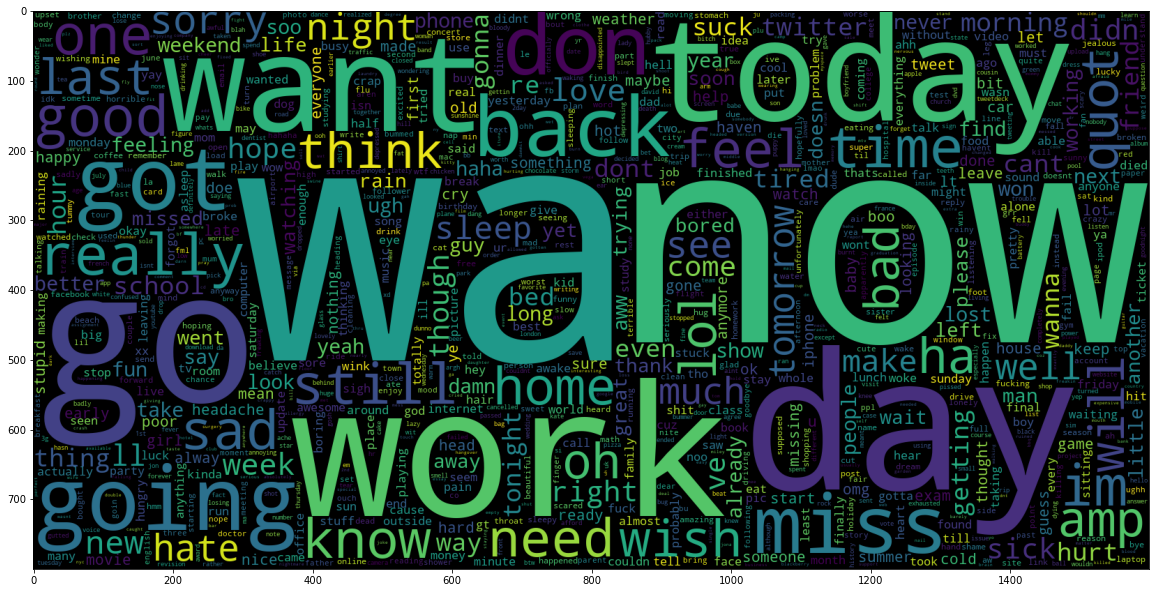

In [ ]:
data_neg = processedTweets[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

### Word-Cloud for Positive tweets.

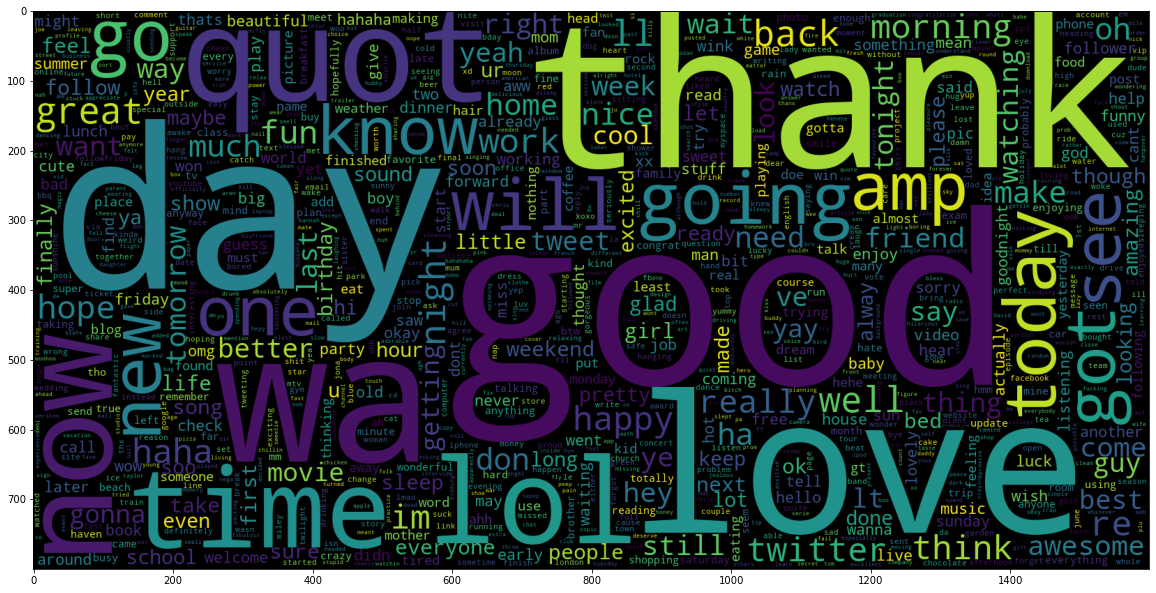

In [ ]:
data_pos = processedTweets[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

## <a name="p5">Splitting the Data</a>
The Preprocessed Data is divided into 2 sets of data: 
* **Training Data:** The dataset upon which the model would be trained on. Contains 95% data.
* **Test Data:** The dataset upon which the model would be tested against. Contains 5% data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processedTweets, sentiment,
                                test_size = 0.1, random_state = 0, shuffle= True)
print(f'Data Split done.')

Data Split done.


## <a name="p6">TF-IDF Vectoriser</a>
**TF-IDF indicates what the importance of the word is in order to understand the document or dataset.** Let us understand with an example. Suppose you have a dataset where students write an essay on the topic, My House. In this dataset, the word a appears many times; it’s a high frequency word compared to other words in the dataset. The dataset contains other words like home, house, rooms and so on that appear less often, so their frequency are lower and they carry more information compared to the word. This is the intuition behind TF-IDF.

**TF-IDF Vectoriser** converts a collection of raw documents to a **matrix of TF-IDF features**. The **Vectoriser** is usually trained on only the **X_train** dataset. 

**max_features** specifies the number of features to consider. *[Ordered by feature frequency across the corpus]*.

In [6]:
vectoriser = TfidfVectorizer(max_features=50000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  50000


### <a name="p7">Tranforming the dataset</a>
Transforming the **X_train** and **X_test** dataset into matrix of **TF-IDF Features** by using the **TF-IDF Vectoriser**. This datasets will be used to train the model and test against it.

In [7]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


## <a name="p8">Creating and Evaluating Models</a>

We're creating 3 different types of model for our sentiment analysis problem: 
* **Multinomial Naive Bayes (MultinomialNB)**
* **Linear Support Vector Classification (LinearSVC)**
* **Logistic Regression (LR)**

Since our dataset is not **skewed**, i.e. it has equal number of **Positive and Negative** Predictions. We're choosing **Accuracy** as our evaluation metric. Furthermore, we're plotting the **Confusion Matrix** to get an understanding of how our model is performing on both classification types.

### <a name="p8-1">MNB Model</a>

Time Taken: 0 seconds
              precision    recall  f1-score   support

           0       0.77      0.78      0.78     79738
           1       0.78      0.77      0.78     80262

    accuracy                           0.78    160000
   macro avg       0.78      0.78      0.78    160000
weighted avg       0.78      0.78      0.78    160000

Score train: 0.7866118055555555
Score test: 0.77648125


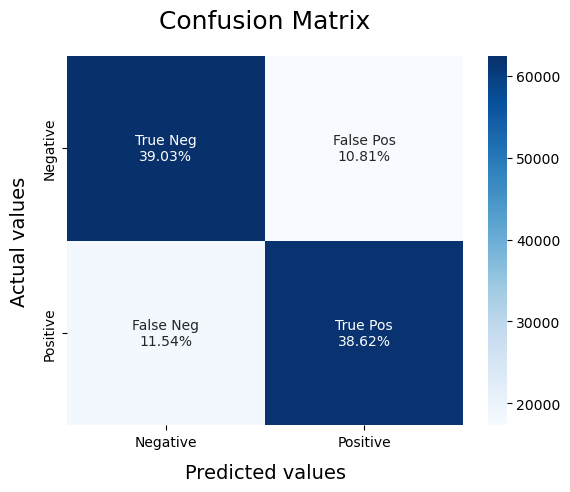

In [16]:
MNBmodel = MultinomialNB(fit_prior = False)

t = time.time()
MNBmodel.fit(X_train, y_train)
print(f'Time Taken: {round(time.time()-t)} seconds')

model_Evaluate(MNBmodel, X_test, y_test)
print("Score train:",MNBmodel.score(X_train, y_train))
print("Score test:", MNBmodel.score(X_test, y_test))

### <a name="p8-2">LinearSVC Model</a>

Time Taken: 71 seconds
              precision    recall  f1-score   support

           0       0.80      0.79      0.79     79738
           1       0.79      0.80      0.80     80262

    accuracy                           0.80    160000
   macro avg       0.80      0.80      0.80    160000
weighted avg       0.80      0.80      0.80    160000

Score train: 0.8104743055555556
Score test: 0.7950875


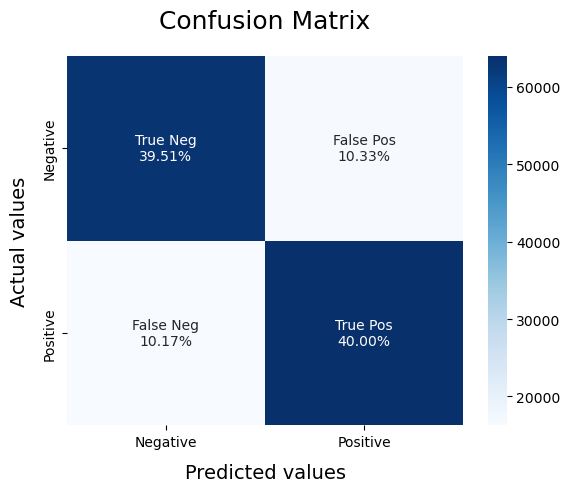

In [17]:
SVCmodel = LinearSVC(fit_intercept = False)

t = time.time()
SVCmodel.fit(X_train, y_train)
print(f'Time Taken: {round(time.time()-t)} seconds')

model_Evaluate(SVCmodel, X_test, y_test)
print("Score train:", SVCmodel.score(X_train, y_train))
print("Score test:", SVCmodel.score(X_test, y_test))

### <a name="p8-3">Logistic Regression Model</a>

Time Taken: 6 seconds
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     79738
           1       0.80      0.80      0.80     80262

    accuracy                           0.80    160000
   macro avg       0.80      0.80      0.80    160000
weighted avg       0.80      0.80      0.80    160000

Score train: 0.8011673611111111
Score test: 0.79710625


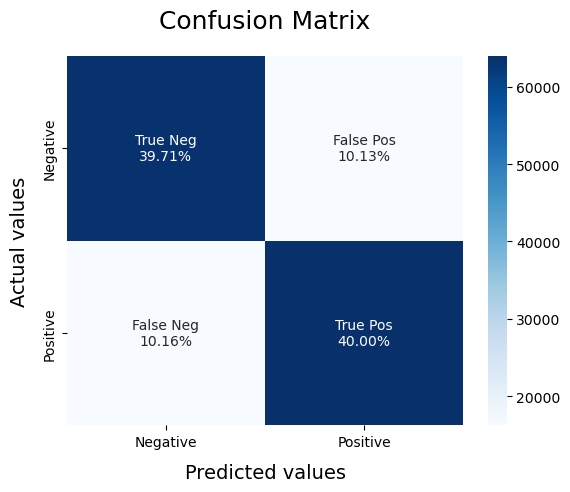

In [18]:
LRmodel = LogisticRegression(
    C = 1, 
    max_iter = 300, 
    n_jobs=-1,
    fit_intercept = False)

t = time.time()
LRmodel.fit(X_train, y_train)
print(f'Time Taken: {round(time.time()-t)} seconds')

model_Evaluate(LRmodel, X_test, y_test)

print("Score train:",LRmodel.score(X_train, y_train))
print("Score test:", LRmodel.score(X_test, y_test))

- We can clearly see that the **Logistic Regression Model** and **Linear SVM** perform better than **MultinomialNB Model**. We will choose logistic regression because of its simplicity and interpretability. It achieves **80% accuracy** while classifying the sentiment of a tweet. 

- Although it should also be noted that the **MultinomialNB Model** is the fastest to train and predict on. It also achieves **78% accuracy** while classifying.

## <a name="p9">Saving the Models</a>
We're using **Joblib** to save **Vectoriser , Logistic Regression Model** for later use.

In [19]:
import joblib

joblib.dump(vectoriser,'../models/vectoriser.pkl')
joblib.dump(LRmodel,'../models/Sentiment-LR.pkl')
joblib.dump(SVCmodel,'../models/Sentiment-SVM.pkl')
joblib.dump(MNBmodel,'../models/Sentiment-MNB.pkl')

['../models/Sentiment-MNB.pkl']